6. Напишите функцию stochastic_gradient_descent, реализующую стохастический градиентный спуск для линейной регрессии. Функция принимает на вход следующие аргументы:

•features - матрица, соответствующая обучающей выборке

•w_init - вектор начальных весов модели

•eta - шаг градиентного спуска (по умолчанию 0.001)

•max_iter - максимальное число итераций градиентного спуска (по умолчанию 10000)

•max_weight_dist - минимальное евклидово расстояние между векторами весов на соседних итерациях градиентного спуска, при котором алгоритм прекращает работу (по умолчанию 1e-8)

•seed - число, используемое для воспроизводимости сгенерированных псевдослучайных чисел (по умолчанию 42)

•verbose - флаг печати информации (например, для отладки, по умолчанию False)

На каждой итерации в вектор (список) должно записываться текущее значение среднеквадратичной ошибки.

Функция должна возвращать вектор весов w, а также вектор (список) ошибок, число итераций


In [1]:
import numpy as np
import pandas as pd
from time import time

from thbmodel.utils import timestamp, YEAR, MONTH,settings
from thbmodel.utils.arrayview import ArrayView, TimeseriesView

from thbmodel.prediction.models.fit_model import TSModel
from thbmodel.prediction.models.model_parameters import ModelParameters
from thbmodel.prediction.models.factor_management import FactorList
from thbmodel.prediction.models.preprocessing import load_slices

from thbmodel.prediction.models.prediction import factornames_trimmed
from thbmodel.prediction.models.parameters import factor_build_end

In [2]:
def softmax(x, axis =1):
    """
    x <= [n,i] tensor 
    axis <= dimention for sum in softmax
    in case np.inf/np.inf = 1.
    return
    sf <= [n,i] tensor answer softmax along axis 
    """
    v_exp = np.exp(x)
    if axis ==1:
        sf = np.divide(v_exp, np.nansum(v_exp, axis =axis).reshape(-1,1))
    else:
        sf = np.divide(v_exp, np.nansum(v_exp, axis =axis))
    mask = np.isnan(sf)
    if mask.any():
        return np.where(mask, 1, sf)
    return sf

In [38]:
def G_step(df_t, winner, t_len, w, verbose=False):
    """ 
    Gradient step 
    return gradient 
    
    df <= [n,i,j] 3d tensor of datas (n) event, (i) -horse, (j) factor
    winner <=  [n,i] 2d tensor (matrix) (n) event, (i) -horse, value 1 if won event else 0
    t_len <= [n] 1d tensor (vector) (n) event, value number of horses in event
    w <=  Model's parameters
    verbose <=  flaf debaging
    """
    b_size,h,f = df_t.shape
    
    S = np.einsum('nij, j -> ni', df_t,w)
    S = np.where(np.isnan(S), -np.inf, S)
    p = softmax(S) 
    delta = winner - p
    
    grad_w = np.zeros_like(w)
    x = np.where(np.isnan(df_t), 0, df_t)
    grad_w = np.einsum('ni, nij -> j', delta, x)
      
    if verbose:
        print 'shape grad_w ',grad_w.shape
        print 'grad_w  ',grad_w[:10]
            
    
    return -np.divide(grad_w,b_size)

In [4]:
def DF_to_tensor(df, features, max_horses =60):
    """
    turn DataFrame to Tensor 
    where each event is in one matrix 
    """
    

    length = df.event_id.unique().__len__()
    f = len(features)
    t_Horses_factors = np.full((length, max_horses, f), np.nan)
    t_winner = np.zeros((length, max_horses))
    t_length = np.zeros(length)
    for  n, (_,df_sub) in enumerate(df.groupby(df['event_id'])):
        h = df_sub.loc[:,features].values.shape[0]
        t_Horses_factors[n, :h,:] = df_sub.loc[:,features].values
        t_winner[n, :h] = (df_sub['result'] ==1).values.astype(int)
        t_length[n] = h
    
    return t_Horses_factors, t_winner, t_length

In [37]:
def Adam (data, features,  w = None, b_size =100, eta=1e-3, N_epoh =10,
                                moment1 = 0.9, moment2 = 0.99, la = 10., max_iter=4e2,
                                eps = 1e-4,  min_weight_dist=1e-3, seed=42, verbose=False):
    """ 
    градиентный спуск с моментом и вторым мометном
    для каждой эпохи выбираем  b_size скачек переходим все итерации
    и повторяем для следующей эпохи
    
    data <= табдица с данными содержащая len(features)-столбцов данных, столбец с номерами - event_id, 
            столбец с результатом - result
    features <=  наименование признаков в данных 
    w <=  начальное приближение для параметров модели
    b_size  <=  размер бача
    eta <=  шаг обучения
    N_epoh <= эпоха
    moment1 <=  первый момент
    moment2 <=  второй момент
    la <=  коффициент регуляризации
    max_iter <=  максимальное число итераций
    eps <=  почти ноль  
    min_weight_dist <=  признак сходимости параметров 
    seed <=  рандомная константа 
    verbose <=  флаг отладки
    """

    
    # Инициализируем расстояние между векторами весов на соседних
    # итерациях большим числом. 
    weight_dist = np.inf
    # для воспроизводимости
    # этой последовательности псевдослучайных чисел используем seed.
    #np.random.seed(seed)
    if w == None:
        w = np.random.normal(0, scale =1e-2, size =(len(features)))
    
    # Step
    iter_num = 0
    # store of grad changes
    grad_norm = np.zeros(max_iter * N_epoh +1)
    # last gradient value
    last_grad = np.zeros_like(w) 
    # last gradient's variation value
    std_grad = np.zeros_like(w)
    # unique events in data set
    events_list = np.unique(data['event_id'])
        
    # Main loop
    for i in range(N_epoh):
        # random choice the events size = b_size
        r_event = np.random.choice(events_list, size = b_size)
        df = data.loc[np.in1d(data['event_id'], r_event),:]
        
        df_t, winner_t, t_len = DF_to_tensor(df, features)
        
        # last gradient value
        #last_grad = np.zeros_like(w) 
        # last gradient's variation value
        #std_grad = np.zeros_like(w)
        
        for iter_num in range(1, max_iter+1):
        
            w_N = w - eta *moment1 *last_grad # for Nesterov momentum
            # get gradient with  Nesterov momemtum + L2 regularisation
            
            grad_ = G_step(df_t, winner_t, t_len, w_N, verbose=False) + la * w_N # gradient and L2
            #grad_ = G_step(df_t, winner_t, t_len, w, verbose=False) + la * w # gradient and L2
            last_grad = moment1 * last_grad + (1-moment1) * grad_ # Update weight first moment estimate 
            std_grad = moment2 * std_grad + (1-moment2)* grad_ * grad_ # Update weight second moment estimate 
            
            t = i * max_iter + iter_num
            last_grad_ = last_grad/(1 - np.power(moment1, t)) # Correct first moment estimate
            std_grad_ = std_grad/(1 - np.power(moment2, t)) # Correct second moment estimate
        
        
            w = w - eta *last_grad_/(np.square(std_grad_) + eps)
        
            weight_dist = np.linalg.norm(last_grad, ord=2)/len(w)
            grad_norm [t] = weight_dist 
            
            if (weight_dist <= min_weight_dist):
                print 'SGD covergence', t
                break
                #return w, grad_norm , iter_num
        
        
        
            if verbose:
                #print 'w  ', w
                print 'iteration', iter_num, 'dist ',weight_dist
        
            if np.any(np.abs(w) == np.inf):
                print "w overcome"
                break
        
    return w, grad_norm ,t

In [39]:
def AdaMax(data, features,  w = None, b_size =100, eta=1e-3, N_epoh =10,
                                moment1 = 0.85, moment2 = 0.99, la = 10., max_iter=1e2,
                                eps = 1e-4,  min_weight_dist=1e-3, seed=42, verbose=False):
    """ 
    градиентный спуск с моментом и вторым мометном
    для каждой эпохи выбираем  b_size скачек переходим все итерации
    и повторяем для следующей эпохи
    
    data <= табдица с данными содержащая len(features)-столбцов данных, столбец с номерами - event_id, 
            столбец с результатом - result
    features <=  наименование признаков в данных 
    w <=  начальное приближение для параметров модели
    b_size  <=  размер бача
    eta <=  шаг обучения
    N_epoh <= эпоха
    moment1 <=  первый момент
    moment2 <=  второй момент
    la <=  коффициент регуляризации
    max_iter <=  максимальное число итераций
    eps <=  почти ноль  
    min_weight_dist <=  признак сходимости параметров 
    seed <=  рандомная константа 
    verbose <=  флаг отладки
    """

    
    # Инициализируем расстояние между векторами весов на соседних
    # итерациях большим числом. 
    weight_dist = np.inf
    # для воспроизводимости
    # этой последовательности псевдослучайных чисел используем seed.
    #np.random.seed(seed)
    if w == None:
        w = np.random.normal(0, scale =1e-2, size =(len(features)))
    
    # store of grad changes
    grad_norm = np.zeros(max_iter * N_epoh +1)
    # last gradient value
    last_grad = np.zeros_like(w) 
    # last gradient's variation value
    std_grad = np.zeros_like(w)
    # unique events in data set
    events_list = np.unique(data['event_id'])
        
    # Main loop
    for i in range(N_epoh):
        # random choice the events size = b_size
        r_event = np.random.choice(events_list, size = b_size)
        df = data.loc[np.in1d(data['event_id'], r_event),:]
        
        df_t, winner_t, t_len = DF_to_tensor(df, features)
        # last gradient value
        #last_grad = np.zeros_like(w) 
        # last gradient's variation value
        #std_grad = np.zeros_like(w)

        
        for iter_num in range(1, max_iter+1):
        
            w_N = w - eta *moment1 *last_grad # for Nesterov momentum
            # get gradient with  Nesterov momemtum + L2 regularisation
            grad_ = G_step(df_t, winner_t, t_len, w_N, verbose=False) + la * w_N # gradient and L2
            #grad_ = G_step(df_t, winner_t, t_len, w, verbose=False) + la * w # gradient and L2
            last_grad = moment1 * last_grad + (1-moment1) * grad_ # Update weight first moment estimate 
            std_grad = np.max(np.vstack((moment2 * std_grad, np.abs(grad_))), axis =0) # Update weight second moment estimate 
        
            t = i * max_iter + iter_num
            last_grad_ = last_grad/(1 - np.power(moment1, t)) # Correct first moment estimate
            
            w = w -  eta *last_grad_/std_grad
        
            weight_dist = np.linalg.norm(last_grad, ord=2)/len(w)
            grad_norm [t] = weight_dist
            #print "t",t
            if (weight_dist <= min_weight_dist):
               # print 'SGD covergence', t
                break
                #return w, grad_norm , t
        
            if verbose:
                #print 'w  ', w
                print 'iteration', iter_num, 'dist ',weight_dist
        
            if np.any(w == np.nan):
                print "w overcome"
                break
        
    return w, grad_norm, t

In [7]:
av = ArrayView.from_file(settings.paths.join('racing_data_azd.av.bcolz'))
tsav = load_slices()

In [8]:
build_end =float(timestamp('2016-04-01'))
oos_start =float(timestamp('2017-05-01'))
pars = ModelParameters(av, build_end =build_end, oos_start =oos_start, depth=1, lmbd=10, verbose=False)

In [9]:
fl = FactorList.from_av(av, factornames_trimmed)
fl.preprocess(pars)
factors = fl.asmatrix()
print 'is1_start  ',(timestamp(av.start_time[pars.is1][0]))
print 'is1_end  ',(timestamp(av.start_time[pars.is1][-1]))
print 'oos_start  ',(timestamp(av.start_time[pars.oos][0]))
print 'oos_end  ',(timestamp(av.start_time[pars.oos][-1]))

is1_start   2016-04-01 12:40:00.000000
is1_end   2017-04-30 16:45:00.000000
oos_start   2017-05-01 12:30:00.000000
oos_end   2017-08-20 15:00:00.000000


In [10]:
# создаем дата фрейм из данных 
def DF(mask, factors, av, factors_names, other_names):
    
    import pandas as pd
    
    df = pd.DataFrame(data =factors[:, mask].T , columns = factors_names)
    for col in other_names :
        
        df[col] = av[col][mask]
        
    return df

In [11]:
import pandas as pd
pd.set_option('display.max_columns', 90)
n,m = factors.shape
col_names = ['f{}'.format(i) for i in range(1,n+1)]

df = DF (pars.model_mask, factors, av, col_names, ['event_id', 'result'])
df['is1'] = pars.is1 [pars.model_mask]
df['is2'] = pars.is2 [pars.model_mask]
df['oos'] = pars.oos [pars.model_mask]


df.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,event_id,result,is1,is2,oos
0,0.367198,-2.822814,1.042788,-1.449000,-0.399689,1.519560,1.120796,-0.903438,2.149808,0.454737,0.397418,2.018940,-0.041120,-1.864951,0.903440,-0.595091,-2.351100,0.791641,-0.371619,-0.134965,0.383271,-1.827844,-0.662651,1.423997,0.518412,0.633018,-0.217998,-0.046744,1.832861,0.362147,1.789398,0.713323,0.847637,2.197710,0.333612,0.992382,2.005222,1.745112,-2.169849,0.024419,0.516602,0.838355,-0.231825,0.510499,-0.818574,1.690850,1.153778,0.0,-0.178424,1.606775,1.276101,0.903439,-0.903432,1.539463,307976,4,True,True,False
1,0.367198,-2.822814,1.146508,-0.950907,0.134657,1.279091,0.709838,0.511180,1.163663,0.554670,0.589283,2.676868,-0.853920,-1.762160,-0.511180,0.355150,0.325790,-0.024739,0.462871,0.297558,1.503070,-1.925740,-0.642401,2.296713,-0.518494,1.678214,-0.325527,0.081803,-0.721549,3.691803,1.126171,1.576948,0.329637,0.138260,1.866920,1.105528,1.685527,1.745112,-1.926777,0.024419,-0.399449,0.838355,1.043211,0.510499,-0.881552,0.215314,0.760771,0.0,-0.103089,1.421764,0.382060,-0.511180,0.511188,-0.341251,307976,1,True,True,False
2,0.367198,-2.269686,1.109573,1.041469,-1.246235,0.959507,0.533713,-0.834292,2.054531,0.589805,0.781147,-0.425354,-0.308430,-1.495752,0.834292,-0.561211,0.570014,-1.385371,0.230456,0.295614,0.221700,-1.316387,-1.368199,0.486579,1.954420,0.373406,-0.280811,0.210350,0.824291,0.099820,0.924145,0.695130,0.329637,-2.094361,0.463911,1.114437,1.611524,1.745112,-1.271665,-0.100011,-0.118486,-1.065489,-0.231825,0.510499,2.544475,-0.108367,-0.777575,0.0,-0.034824,0.366740,0.442908,0.834292,-0.834286,0.687687,307976,2,True,True,False
3,0.367198,-2.082636,-0.546706,1.041469,-0.177928,0.807879,1.825297,0.377624,-0.891473,2.359050,0.690858,-1.025506,2.586447,-1.542717,-0.377623,0.483454,0.439499,-1.929624,-0.011781,0.218581,1.028220,-0.193052,-0.390140,-0.525911,0.543346,0.061765,-0.134161,0.210350,-1.481083,-1.201241,-0.343101,-0.052652,-0.188364,0.024540,-0.598031,-0.847758,1.648525,1.745112,-0.854125,-0.057719,-0.967518,-1.950998,-0.231825,0.510499,-0.705213,-0.063721,0.946241,0.0,0.028652,0.979326,3.985849,-0.377623,0.377629,1.750346,307976,5,True,True,False
4,0.367198,-1.620791,0.904502,1.041469,-0.645139,0.037615,-0.229496,-0.471971,1.330716,1.717160,0.167181,-0.232777,-0.308430,-0.513871,0.471972,-0.296116,0.195127,-1.385371,0.358433,0.311468,1.782793,-1.105682,-0.162607,-0.525911,1.667236,1.301977,-0.517036,0.210350,0.340718,4.356093,0.522335,1.517120,-0.188364,-1.785856,1.200810,0.854792,0.270584,1.745112,-0.640691,0.049978,-0.749274,-0.453683,-0.231825,0.510499,2.587987,-0.043631,1.434019,0.0,-0.145211,1.003482,0.699005,0.471972,-0.471966,0.365180,307976,8,True,True,False


In [12]:
def LL_f (df_t, winner, w):
    
    S = np.einsum('nij, j -> ni', df_t,w) 
    S = np.where(np.isnan(S), -np.inf, S)
    p = softmax(S)  
    LL = np.log(np.einsum('ni, ni -> n', p, winner)).mean()
    
    return LL

In [13]:
import time
start = time.time()
df_train_t, winner_tr_t, t_len_tr = DF_to_tensor(df.loc[df.is1.values,:], col_names)
df_test_t, winner_ts_t, t_len_ts = DF_to_tensor(df.loc[df.oos.values,:], col_names)
end = time.time()
print 'DataFrame to tensors {}'.format(end -start)

DataFrame to tensors 25.9808678627


In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
import time

SGD_models =[]


for b_size in [10, 100, 500, 1000, 2500, 5000, 10000]:
    start = time.time()
    N_epoh = 12000/b_size +2
    SGD_models.append(AdaMax(df.loc[df.is1.values,:], col_names, b_size =b_size, eta = 1e-3, N_epoh =N_epoh, \
                             moment1 = 0.95,  la = 10., moment2 =0.99, max_iter =100, verbose=False))
    end = time.time()
    print 'Time taken to stohastic gradient {}  b_size {}'.format(end - start, b_size)

Time taken to stohastic gradient 31.8520970345  b_size 10
Time taken to stohastic gradient 20.4905450344  b_size 100
Time taken to stohastic gradient 18.8439450264  b_size 500
Time taken to stohastic gradient 18.833411932  b_size 1000
Time taken to stohastic gradient 20.1820650101  b_size 2500
Time taken to stohastic gradient 24.6936030388  b_size 5000
Time taken to stohastic gradient 33.7765619755  b_size 10000


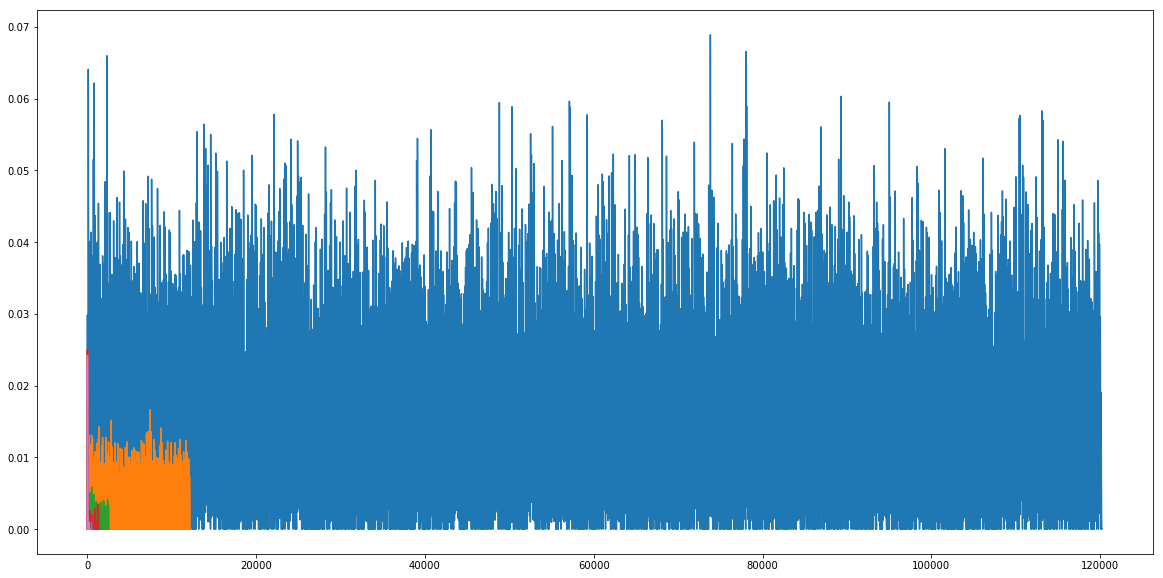

0.00097905301381
0.000974317366121
0.000975641284628
0.000965636052717
0.000935135385835
0.000876523550337
0.000913975994406


In [37]:
plt.figure(figsize=(20, 10))
for mod in SGD_models:
    plt.plot(mod[1])
plt.show()
for mod in SGD_models:
    print mod[1][mod[1] >0][-1]

In [34]:
for mod in SGD_models:
    w0 = mod[0] # return to original shape
    start = time.time()
    likelihood = LL_f (df_train_t, winner_tr_t, w0)
    end = time.time()
    print 'count ll for train data {} by AdaMax'.format(end -start)
    print likelihood

count ll for train data 0.036110162735 by AdaMax
-2.08122143441
count ll for train data 0.038104057312 by AdaMax
-2.07560569485
count ll for train data 0.0423369407654 by AdaMax
-2.07715414682
count ll for train data 0.0343680381775 by AdaMax
-2.07617312837
count ll for train data 0.0335559844971 by AdaMax
-2.07212752423
count ll for train data 0.0328760147095 by AdaMax
-2.06934824056
count ll for train data 0.0343079566956 by AdaMax
-2.07333396835


In [48]:
import time

SGD_models =[]
la_list = [0.5, 1., 2., 4., 7., 10.]
mom2_list = [0.97, 0.975, 0.98, 0.985, 0.99]

for mom in mom2_list:
    start = time.time()
    #N_epoh = 12000/b_size +2
    SGD_models.append(AdaMax(df.loc[df.is1.values,:], col_names, b_size =1000, eta = 1e-4, N_epoh =14, \
                             moment1 = 0.98,  la = 0.8, moment2 =mom, max_iter =100, verbose=False))
    end = time.time()
    print 'Time taken to stohastic gradient {}  moment2 {}'.format(end - start, mom)

Time taken to stohastic gradient 31.326196909  moment2 0.97
Time taken to stohastic gradient 31.6684310436  moment2 0.975
Time taken to stohastic gradient 31.5104269981  moment2 0.98
Time taken to stohastic gradient 33.4433581829  moment2 0.985
Time taken to stohastic gradient 32.7190730572  moment2 0.99


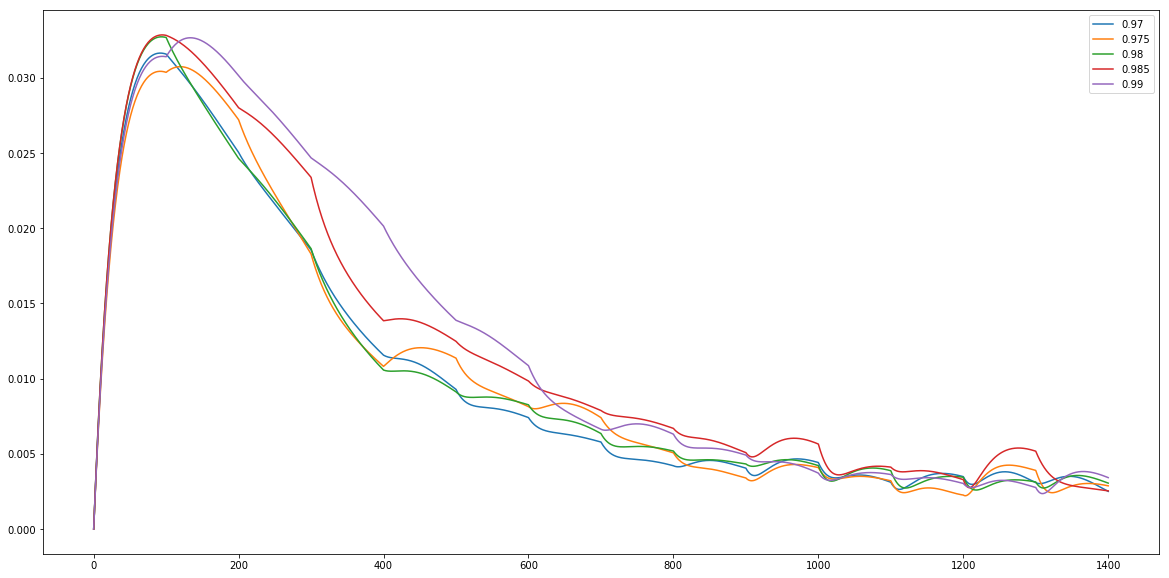

0.00250786279909
0.00287634757562
0.00305599591138
0.00254100409915
0.00342117215045


In [49]:
plt.figure(figsize=(20, 10))
for mod, mom in zip(SGD_models, mom2_list):
    plt.plot(mod[1], label =str(mom))
plt.legend()
plt.show()
for mod in SGD_models:
    print mod[1][mod[1] >0][-1]

In [50]:
for mod in SGD_models:
    w0 = mod[0] # return to original shape
    start = time.time()
    likelihood = LL_f (df_train_t, winner_tr_t, w0)
    end = time.time()
    print 'count ll for train data {} by AdaMax'.format(end -start)
    print likelihood

count ll for train data 0.0362949371338 by AdaMax
-1.96049817456
count ll for train data 0.0438470840454 by AdaMax
-1.95754468365
count ll for train data 0.0367388725281 by AdaMax
-1.95817569891
count ll for train data 0.0367059707642 by AdaMax
-1.96265042374
count ll for train data 0.036789894104 by AdaMax
-1.95845607724


In [51]:
for mod in SGD_models:
    w0 = mod[0] # return to original shape
    start = time.time()
    likelihood = LL_f (df_test_t, winner_ts_t, w0)
    end = time.time()
    print 'count ll for test data {} by AdaMax'.format(end -start)
    print likelihood

count ll for test data 0.0130610466003 by AdaMax
-1.97243765905
count ll for test data 0.0130729675293 by AdaMax
-1.96960232111
count ll for test data 0.0173010826111 by AdaMax
-1.96880589937
count ll for test data 0.0131759643555 by AdaMax
-1.97570274178
count ll for test data 0.0127251148224 by AdaMax
-1.96998096864


In [30]:
import time

SGD_models =[]
la_list = [0.5, 1., 2., 4., 7., 10.]
mom2_list = [0.97, 0.975, 0.98, 0.985, 0.99]

for mom in mom2_list:
    start = time.time()
    #N_epoh = 12000/b_size +2
    SGD_models.append(Adam(df.loc[df.is1.values,:], col_names, b_size =2500, eta = 1e-4, N_epoh =7, \
                             moment1 = 0.97,  la = 0.8, moment2 =mom, max_iter =100, verbose=False))
    end = time.time()
    print 'Time taken to stohastic gradient {}  moment2 {}'.format(end - start, mom)

SGD covergence 120
SGD covergence 201
SGD covergence 301
SGD covergence 401
SGD covergence 501
SGD covergence 601
Time taken to stohastic gradient 25.4124238491  moment2 0.97
SGD covergence 94
SGD covergence 101
SGD covergence 201
SGD covergence 301
SGD covergence 401
SGD covergence 501
SGD covergence 601
Time taken to stohastic gradient 26.1545050144  moment2 0.975
SGD covergence 92
SGD covergence 101
SGD covergence 201
SGD covergence 301
SGD covergence 401
SGD covergence 501
SGD covergence 601
Time taken to stohastic gradient 26.0107879639  moment2 0.98
SGD covergence 100
SGD covergence 101
SGD covergence 201
SGD covergence 301
SGD covergence 401
SGD covergence 501
SGD covergence 601
Time taken to stohastic gradient 24.9049859047  moment2 0.985
SGD covergence 94
SGD covergence 101
SGD covergence 201
SGD covergence 301
SGD covergence 401
SGD covergence 501
SGD covergence 601
Time taken to stohastic gradient 24.5841519833  moment2 0.99


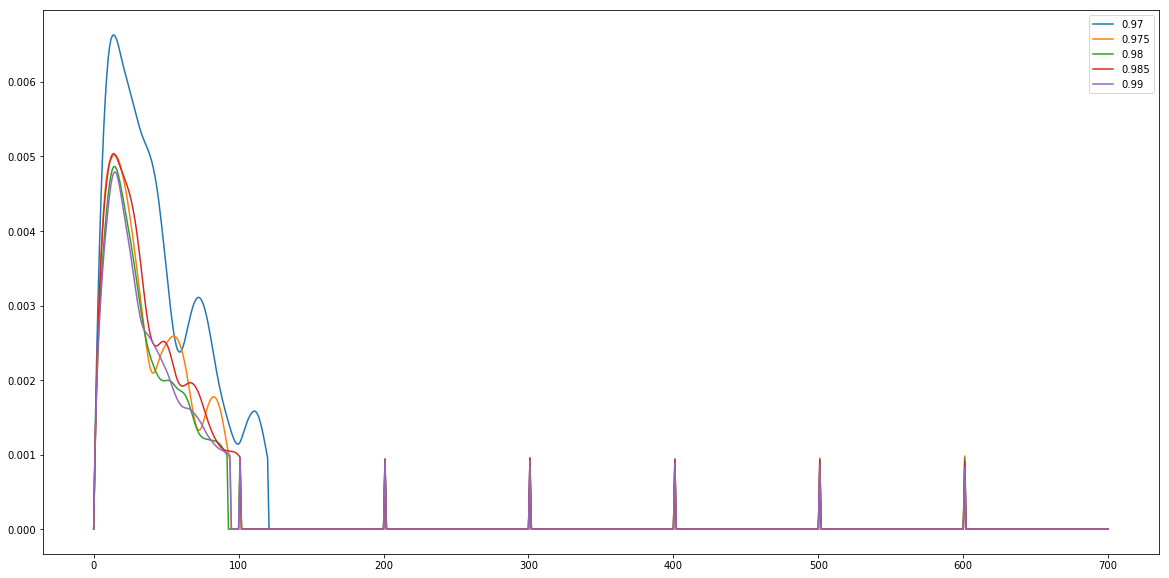

0.000621899164968
0.000981296181947
0.000956578506442
0.000910795501033
0.000824883245516


In [31]:
plt.figure(figsize=(20, 10))
for mod, mom in zip(SGD_models, mom2_list):
    plt.plot(mod[1], label =str(mom))
plt.legend()
plt.show()
for mod in SGD_models:
    print mod[1][mod[1] >0][-1]

In [34]:
for mod in SGD_models:
    w0 = mod[0] # return to original shape
    start = time.time()
    likelihood = LL_f (df_train_t, winner_tr_t, w0)
    end = time.time()
    print 'count ll for train data {} by Adam'.format(end -start)
    print likelihood

count ll for train data 0.0393528938293 by Adam
-1.95488834586
count ll for train data 0.0472981929779 by Adam
-1.95944337371
count ll for train data 0.0378329753876 by Adam
-1.96406105888
count ll for train data 0.0402109622955 by Adam
-1.9653905276
count ll for train data 0.0338108539581 by Adam
-1.96980057545


In [35]:
for mod in SGD_models:
    w0 = mod[0] # return to original shape
    start = time.time()
    likelihood = LL_f (df_test_t, winner_ts_t, w0)
    end = time.time()
    print 'count ll for test data {} by Adam'.format(end -start)
    print likelihood

count ll for test data 0.0307059288025 by Adam
-1.9644188452
count ll for test data 0.014212846756 by Adam
-1.97043560811
count ll for test data 0.0125069618225 by Adam
-1.97791942627
count ll for test data 0.0129661560059 by Adam
-1.97870846064
count ll for test data 0.0151131153107 by Adam
-1.98360145398


In [ ]:
for i in range(10):
    
    W1 = np.random.normal(loc =w0, scale =1e-2, size =(len(col_names)))
    print 'train  ',LL_f (df_train_t, winner_tr_t, W1)
    print 'test  ',LL_f (df_test_t, winner_ts_t, W1)